In [1]:
import os
import random
import optuna
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from multiprocessing import Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/home/jsd/miniconda3/envs/pyml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-29 18:29:24.776361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 18:29:24.855024: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 18:29:24.934851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 18:29:25.020251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 18:29:2

<a id="s1"></a>
### 1. Análisis exploratorio de datos

In [2]:
# data path
data_dir = 'dataset/english.csv'
img_dir = 'dataset/'

In [3]:
# load data
data = pd.read_csv(data_dir)

X_path = data['image']
y = data['label']

X_path = [os.path.join(img_dir, path) for path in X_path]


In [4]:
# dataset information
print(data.head())

print(f"\nNúmero de ejemplos: {len(data)}")
print(f"\nClases únicas: {data['label'].unique()}")

                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0

Número de ejemplos: 3410

Clases únicas: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


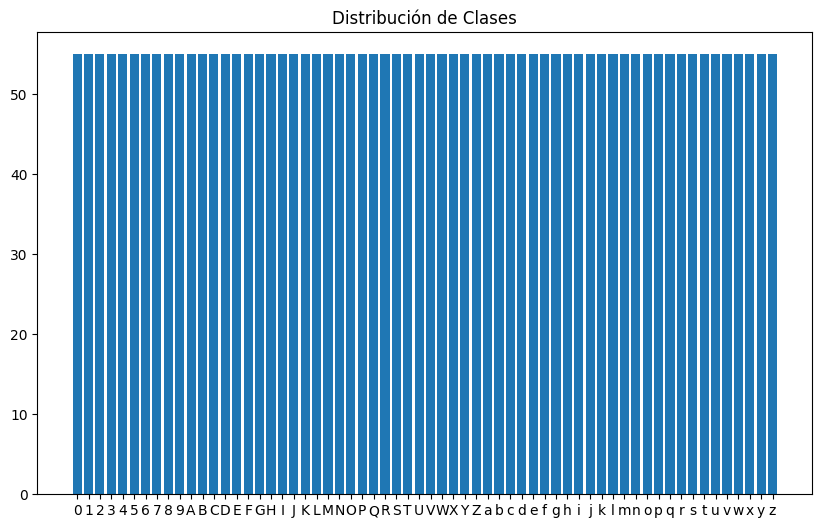

In [5]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(Counter(y).keys(), Counter(y).values())
plt.title("Distribución de Clases")
plt.show()

In [6]:
pixel_values = []
for path in X_path[:10]:  # Analizar las primeras 10 imágenes
    img = plt.imread(path)
    pixel_values.extend(img.flatten())

print(f"Valor mínimo de píxel: {min(pixel_values)}")
print(f"Valor máximo de píxel: {max(pixel_values)}")
print(f"Valor promedio de píxel: {np.mean(pixel_values)}")

Valor mínimo de píxel: 0.0
Valor máximo de píxel: 1.0
Valor promedio de píxel: 0.9343602657318115


In [7]:
# Función para redimensionar y normalizar usando scikit-image
def resize_and_normalize(image_path, target_size=(64, 64)):
    try:
        img = load_img(image_path, target_size=target_size, color_mode='grayscale')
        return img_to_array(img) / 255.0

    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")
        return None

# Procesamiento paralelo
def process_images(X_path, target_size):
    with Pool() as pool:
        X_processed = pool.starmap(resize_and_normalize, [(path, target_size) for path in X_path])
    return np.array([img for img in X_processed if img is not None])

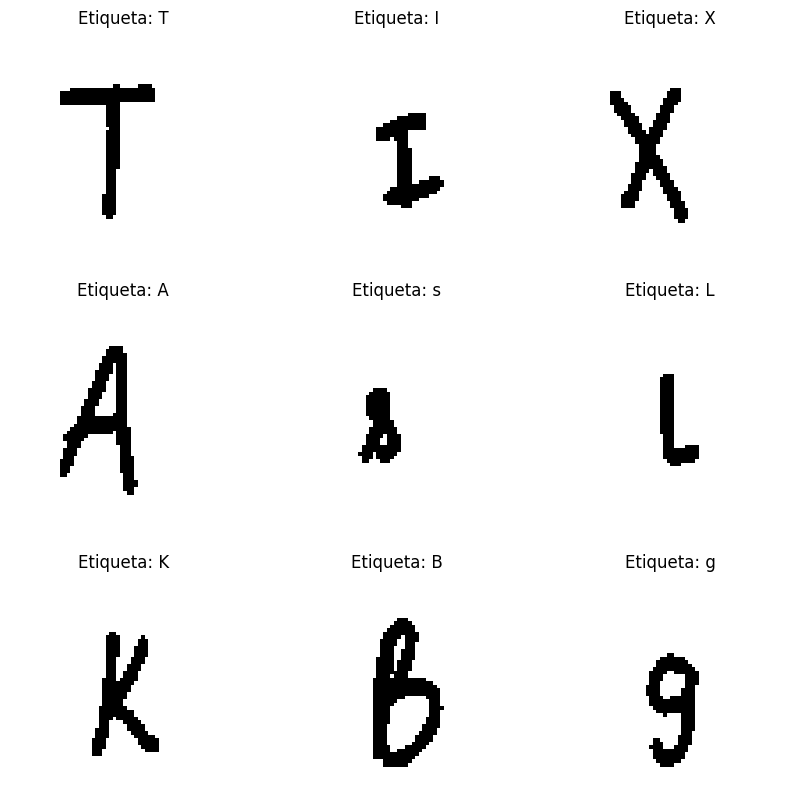

In [8]:
target_size = (64, 64)
X_processed = process_images(X_path, target_size)

# Visualización de algunas imágenes procesadas
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    idx = random.randint(0, len(X_path) - 1)
    plt.imshow(X_processed[idx], cmap='gray')
    plt.title(f"Etiqueta: {y[idx]}")
    plt.axis('off')
plt.show()

Forma del array de imágenes procesadas: (3410, 64, 64, 1)
Valor mínimo: 0.0
Valor máximo: 1.0


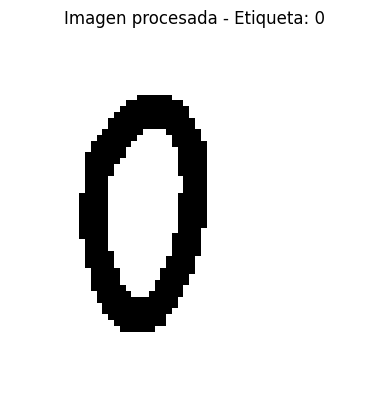

In [9]:
print("Forma del array de imágenes procesadas:", X_processed.shape)
print("Valor mínimo:", X_processed.min())
print("Valor máximo:", X_processed.max())

plt.imshow(X_processed[0], cmap='gray')
plt.title(f"Imagen procesada - Etiqueta: {y[0]}")
plt.axis('off')
plt.show()

In [10]:
# aumento de datos
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotación aleatoria en el rango de +/- 15 grados
    zoom_range=0.1,     # Zoom aleatorio de hasta +/- 10%
    width_shift_range=0.1,  # Desplazamiento horizontal de hasta +/- 10%
    height_shift_range=0.1, # Desplazamiento vertical de hasta +/- 10%
    fill_mode='nearest',     # Método para rellenar píxeles nuevos
)

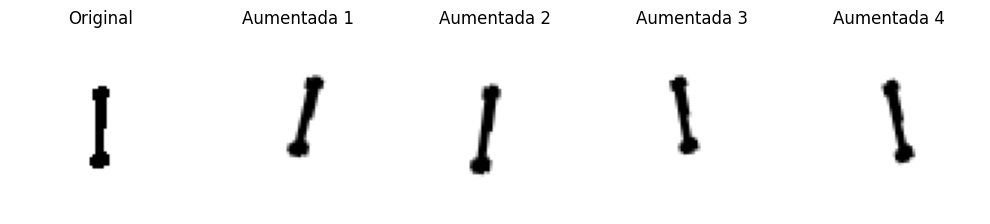

In [11]:
def plot_augmented_images(original_image, num_augmented=4):
    plt.figure(figsize=(10, 10))
    
    # Mostrar la imagen original
    plt.subplot(1, num_augmented + 1, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    # Generar y mostrar imágenes aumentadas
    for i in range(num_augmented):
        augmented = datagen.random_transform(original_image)
        plt.subplot(1, num_augmented + 1, i + 2)
        plt.imshow(augmented, cmap='gray')
        plt.title(f'Aumentada {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_augmented_images(X_processed[random.randint(0, len(X_processed) - 1)])

In [12]:
def augment_data(X, y, num_augmented_per_image=5):
    X_augmented = []
    y_augmented = []
    
    for image, label in zip(X, y):
        X_augmented.append(image)
        y_augmented.append(label)
        
        for _ in range(num_augmented_per_image):
            aug_image = datagen.random_transform(image)
            X_augmented.append(aug_image)
            y_augmented.append(label)
    
    return np.array(X_augmented), np.array(y_augmented)

# Aplicar la aumentación
X_aug, y_aug = augment_data(X_processed, y, num_augmented_per_image=5)

print("Forma original del conjunto de datos:", X_processed.shape)
print("Forma del conjunto de datos aumentado:", X_aug.shape)

Forma original del conjunto de datos: (3410, 64, 64, 1)
Forma del conjunto de datos aumentado: (20460, 64, 64, 1)


In [13]:
def split_data(X, y, test_size=0.2, val_size=0.2):
    # Primero, separamos el conjunto de prueba
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      stratify=y, 
                                                      random_state=42)
    
    # Luego, del resto, separamos el conjunto de validación
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                      test_size=val_size_adjusted, 
                                                      stratify=y_temp, 
                                                      random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# separar los datos
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_aug, y_aug)

# Imprimir las formas de los conjuntos resultantes
print("Formas de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Validación: {X_val.shape}, {y_val.shape}")
print(f"Prueba: {X_test.shape}, {y_test.shape}")

# Verificar la distribución de clases en cada conjunto
def check_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

Formas de los conjuntos de datos:
Entrenamiento: (12276, 64, 64, 1), (12276,)
Validación: (4092, 64, 64, 1), (4092,)
Prueba: (4092, 64, 64, 1), (4092,)


# 2. Modelos de Machine Learning

In [14]:
# configuracón de experimentos
mlflow.set_experiment("handwritten recognition")

<Experiment: artifact_location='file:///home/jsd/Documents/unal/semestre%205/aprendizaje%20automatico/proyecto/mlruns/886941718899558242', creation_time=1724908538946, experiment_id='886941718899558242', last_update_time=1724908538946, lifecycle_stage='active', name='handwritten recognition', tags={}>

In [15]:
# Aplanar las imágenes para SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Forma de los datos aplanados:", X_train_flat.shape)

Forma de los datos aplanados: (12276, 4096)


In [16]:
def register_model(model, model_name, metrics):
    with mlflow.start_run():
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, model_name)

#### 2.1 support vector machine (SVM)

In [17]:
metrics = {} # diccionario para almacenar el accuracy de train , val y test

In [18]:
# Definir el modelo SVM
svm = SVC()

# Entrenamiento inicial del modelo
svm.fit(X_train_flat, y_train)

In [20]:
# datos de entrenamiento
y_train_pred = svm.predict(X_train_flat)
metrics['train accuracy'] = accuracy_score(y_train, y_train_pred)
print("Accuracy en entrenameinto:", metrics['train accuracy'])
print(classification_report(y_train, y_train_pred))

In [51]:
# Validacíon
y_val_pred = svm.predict(X_val_flat)
metrics['val accuracy'] = accuracy_score(y_val, y_val_pred)
print("Accuracy en validación:", metrics['val accuracy'])
print(classification_report(y_val, y_val_pred))

Accuracy en validación: 0.44501466275659823
              precision    recall  f1-score   support

           0       0.27      0.29      0.28        66
           1       0.24      0.33      0.28        66
           2       0.51      0.52      0.51        66
           3       0.47      0.41      0.44        66
           4       0.27      0.32      0.29        66
           5       0.66      0.32      0.43        66
           6       0.66      0.38      0.48        66
           7       0.36      0.42      0.39        66
           8       0.41      0.52      0.46        66
           9       0.18      0.38      0.25        66
           A       0.74      0.48      0.59        66
           B       0.42      0.42      0.42        66
           C       0.57      0.68      0.62        66
           D       0.51      0.58      0.54        66
           E       0.72      0.55      0.62        66
           F       0.62      0.50      0.55        66
           G       0.46      0.50    

In [54]:
# Evaluación en el conjunto de prueba
y_test_pred = svm.predict(X_test_flat)
metrics['test accuracy'] = accuracy_score(y_test, y_test_pred)
print("Accuracy en prueba:", metrics['test accuracy'])
print(classification_report(y_test, y_test_pred))

Accuracy en prueba: 0.44452590420332355
              precision    recall  f1-score   support

           0       0.25      0.27      0.26        66
           1       0.25      0.39      0.31        66
           2       0.50      0.44      0.47        66
           3       0.54      0.48      0.51        66
           4       0.24      0.30      0.27        66
           5       0.52      0.35      0.42        66
           6       0.64      0.42      0.51        66
           7       0.38      0.47      0.42        66
           8       0.33      0.35      0.34        66
           9       0.24      0.48      0.32        66
           A       0.53      0.50      0.52        66
           B       0.42      0.41      0.42        66
           C       0.60      0.70      0.64        66
           D       0.54      0.47      0.50        66
           E       0.68      0.55      0.61        66
           F       0.67      0.56      0.61        66
           G       0.45      0.50      0.

In [64]:
register_model(svm, 'svc base model', metrics)

/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/29 04:19:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Alta varianza, alto bias, se usara optuna para realizar una busqueda de un modelo más optimo

In [76]:
def objective_svc(trial):
    C = trial.suggest_float('C', 0.1, 100, log=True)
    gamma = trial.suggest_categorical('gamma', ['auto', 'scale', 0.1, 1, 10])
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    
    svc = SVC(C=C, gamma=gamma, kernel=kernel)
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svc)
    ])
    
    score = cross_val_score(pipeline, X_train_flat, y_train, n_jobs=-1, cv=5)
    return score.mean()
    

In [77]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_svc, n_trials=100)

[I 2024-08-29 04:49:24,789] A new study created in memory with name: no-name-b4d4cac0-8bec-4ce5-b7c9-b4c6dddf1fec
[W 2024-08-29 05:00:08,439] Trial 0 failed with parameters: {'C': 3.0460912899130594, 'gamma': 1, 'kernel': 'linear'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_33/3613625000.py", line 12, in objective_svc
    score = cross_val_score(pipeline, X_train_flat, y_train, n_jobs=-1, cv=5)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return 

KeyboardInterrupt: 

In [ ]:
print('Número de trials finalizados:', len(study.trials))
print('Mejores hiperparámetros:', study.best_params)
print('Mejor score:', study.best_value)

In [66]:
metrics = {}

In [ ]:
# Crear el mejor modelo encontrado
best_svc = SVC(**study.best_params)
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', best_svc)
])

In [ ]:
# Entrenar el mejor modelo
best_pipeline.fit(X_train, y_train)

In [ ]:
# datos de entrenamiento
y_trian_pred = svm.predict(X_test_flat)
metrics['train accuracy'] = accuracy_score(y_train, y_train_pred)
print("Accuracy en entrenameinto:", metrics['train accuracy'])
print(classification_report(y_train, y_train_pred))

In [ ]:
# Validacíon
y_val_pred = svm.predict(X_val_flat)
metrics['val accuracy'] = accuracy_score(y_val, y_val_pred)
print("Accuracy en validación:", metrics['val accuracy'])
print(classification_report(y_val, y_val_pred))

In [ ]:
# Evaluación en el conjunto de prueba
y_test_pred = svm.predict(X_test_flat)
metrics['test accuracy'] = accuracy_score(y_test, y_test_pred)
print("Accuracy en prueba:", metrics['test accuracy'])
print(classification_report(y_test, y_test_pred))